In [1]:
import ibapi
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract
from ibapi.order import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
import tensorflow as tf
from tensorflow import keras
from time import sleep
from datetime import datetime, date, timedelta, time
from sklearn.preprocessing import MinMaxScaler
import threading
from decimal import *


scaler = MinMaxScaler()
df = pd.read_csv('C:\\src\\stockPredictor\\SpyHist.csv', index_col=0)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['date'] = [d.date() for d in df['DateTime']]
df['time'] = [d.time() for d in df['DateTime']]
df['Open'] = df['Open'].astype(float)
df['Close'] = df['Close'].astype(float)
df['Volume'] = df['Volume'].astype(int)
df['slowsma'] = df['Close'].rolling(21).mean()
df['fastsma'] = df['Close'].rolling(9).mean()
df['Difference'] = df['Close'] - df['Open']
df = df.dropna()
df[['scalars']] = scaler.fit_transform(df[['Difference']])

for currentDate in df.date.unique():
    if len(df.date.unique()) > len(df.loc[df['date'] == currentDate]):
        df = df.loc[df['date'] != currentDate]

lastDate = df.date.unique()[-1]
yesterdaysDate = datetime.today() - timedelta(days=2)
if True:
    class IBapi(EWrapper, EClient):
        def __init__(self):
            EClient.__init__(self, self)
            self.data = [] #Initialize variable to store candle

        def historicalData(self, reqId, bar):
            self.data.append([bar.date, bar.open, bar.close])
            
    def run_loop():
        app.run()

    app = IBapi()
    app.connect('127.0.0.1', 7496, 124)

    #Start the socket in a thread
    api_thread = threading.Thread(target=run_loop, daemon=True)
    api_thread.start()

    sleep(1) #Sleep interval to allow time for connection to server

    #Create contract object
    contract = Contract()
    contract.symbol = 'SPY'
    contract.secType = 'STK'
    contract.exchange = 'SMART'
    contract.currency = 'USD'

    #Request historical candles
    app.reqHistoricalData(1, contract, yesterdaysDate.strftime('%Y%m%d 16:00:00') + ' US/Eastern', '5 D', '5 mins', 'TRADES', 1, 2, False, [])

    sleep(8) #sleep to allow enough time for data to be returned

    #change back to app.data
    newWholeData = pd.DataFrame(app.data, columns=['DateTime', 'Open', 'Close'])
    newWholeData['DateTime'] = pd.to_datetime(newWholeData['DateTime'],unit='s').dt.tz_localize(tz='UTC')
    newWholeData['DateTime'] = newWholeData['DateTime'].dt.tz_convert(tz='US/Eastern')
    newWholeData['date'] = [d.date() for d in newWholeData['DateTime']]
    newWholeData['time'] = [d.time() for d in newWholeData['DateTime']]
    newWholeData['Difference'] = newWholeData['Close'] - newWholeData['Open']
    newWholeData[['scalars']] = scaler.transform(newWholeData[['Difference']])

    df = pd.concat([df, newWholeData[~newWholeData['DateTime'].isin(df['DateTime'])]], ignore_index=True).dropna()

    df.to_csv('SpyHist.csv')  
    app.disconnect()
    count = 0
    maxSteps = len(df.time.unique())

    for i in range(1, maxSteps - 1):
        # Create sequences of past and future data
        X = []
        y = []

        for currentDate in df.date.unique():
            past_sequence = df.loc[df['date']==currentDate][0:i]['scalars']
            future_sequence = df[df['date']==currentDate][i:maxSteps]['scalars']
            X.append(past_sequence)
            y.append(future_sequence)

        X = np.array(X)
        y = np.array(y)

        # Reshape the data for LSTM (batch_size, timesteps, input_dim)
        X = X.reshape(-1, i, 1)
        y = y.reshape(-1, maxSteps - i, 1)
        
        # Define the model
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(i, 1)))
        model.add(Dense(maxSteps - i))
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train the model (you can adjust the number of epochs and batch size)
        model.fit(X, y, epochs=20, batch_size=32)
        
        model.save('model_'+str(df.time.unique()[i-1]).replace(':','_')+'.keras')

while True:    
    if datetime.today().time() > time(10, 5) and datetime.today().time() < time(15, 55):

        long = False
        short = False
        lastPrice = 0
        totalWin = 0

        class IBapi(EWrapper, EClient):
            def __init__(self):
                EClient.__init__(self, self)
                self.data = [] #Initialize variable to store candle

            def historicalData(self, reqId, bar):
                self.data.append([bar.date, bar.open, bar.close])

            def historicalDataUpdate(self, reqId, bar):
                self.data.append([bar.date, bar.open, bar.close])

            def nextValidId(self, orderId: int):
                super().nextValidId(orderId)
                self.nextorderId = orderId
                print('The next valid order id is: ', self.nextorderId)

            def orderStatus(self, orderId, status, filled, remaining, avgFullPrice, permId, parentId, lastFillPrice, clientId, whyHeld, mktCapPrice):
                print('orderStatus - orderid:', orderId, 'status:', status, 'filled', filled, 'remaining', remaining, 'lastFillPrice', lastFillPrice)
            
            def openOrder(self, orderId, contract, order, orderState):
                print('openOrder id:', orderId, contract.symbol, contract.secType, '@', contract.exchange, ':', order.action, order.orderType, order.totalQuantity, orderState.status)

            def execDetails(self, reqId, contract, execution):
                print('Order Executed: ', reqId, contract.symbol, contract.secType, contract.currency, execution.execId, execution.orderId, execution.shares, execution.lastLiquidity)
                
            def position(self, account: str, contract: Contract, position: Decimal, avgCost: float):
                super().position(account, contract, position, avgCost)
                print("Position.", "Account:", account, "Symbol:", contract.symbol, "SecType:", contract.secType, "Currency:", contract.currency,"Position:", decimalMaxString(position), "Avg cost:", floatMaxString(avgCost))
                
        def run_loop():
            app.run()

        app = IBapi()
        app.connect('127.0.0.1', 7496, 125)

        #Start the socket in a thread
        api_thread = threading.Thread(target=run_loop, daemon=True)
        api_thread.start()

        sleep(1) #Sleep interval to allow time for connection to server

        #Create contract object
        contract = Contract()
        contract.symbol = 'SPY'
        contract.secType = 'STK'
        contract.exchange = 'SMART'
        contract.currency = 'USD'
                
        #Create order object
        buyOrder = Order()
        buyOrder.action = 'BUY'
        buyOrder.totalQuantity = 100
        buyOrder.orderType = 'MKT'

        sellOrder = Order()
        sellOrder.action = 'SELL'
        sellOrder.totalQuantity = 100
        sellOrder.orderType = 'MKT'

        buyBigOrder = Order()
        buyBigOrder.action = 'BUY'
        buyBigOrder.totalQuantity = 200
        buyBigOrder.orderType = 'MKT'

        sellBigOrder = Order()
        sellBigOrder.action = 'SELL'
        sellBigOrder.totalQuantity = 200
        sellBigOrder.orderType = 'MKT'


        while datetime.today().time() > time(10, 5) and datetime.today().time() < time(15, 55): 
            
            #Request historical candles
            app.data = []
            app.reqHistoricalData(1, contract, '', '1 D', '5 mins', 'TRADES', 1, 2, False, [])
            sleep(10) #sleep to allow enough time for data to be returned
            todaysData = pd.DataFrame(app.data, columns=['DateTime', 'Open', 'Close'])
            try:
                todaysData['DateTime'] = pd.to_datetime(todaysData['DateTime'],unit='s').dt.tz_localize(tz='UTC')
                todaysData['DateTime'] = todaysData['DateTime'].dt.tz_convert(tz='US/Eastern')
                todaysData['Open'] = todaysData['Open'].astype(float)
                todaysData['Close'] = todaysData['Close'].astype(float)
                todaysData['date'] = [d.date() for d in todaysData['DateTime']]
                todaysData['time'] = [d.time() for d in todaysData['DateTime']]
                todaysData['Difference'] = todaysData['Close'] - todaysData['Open']
                todaysData[['scalars']] = scaler.transform(todaysData[['Difference']])

            except:
                print('error loading data')

            currentTick = todaysData.iloc[-1]
            todaysData = todaysData.loc[todaysData['time'].isin(df.time.unique())]
            model = tf.keras.models.load_model('model_'+str(todaysData.iloc[-1]['time']).replace(':','_')+'.keras')
                        
            X = np.array(todaysData['scalars'])
            input_sequence = X.reshape(1, len(todaysData), 1)
            predicted_sequence = scaler.inverse_transform(model.predict(input_sequence))
            
            dfTotal = pd.DataFrame(columns=['Total','Time'])
            total = 0
            highest = 0
            crossoverHighest = 0
            positive = predicted_sequence[0][0] > 0
            
            for i in range(0,len(predicted_sequence[0])):
                total = total + predicted_sequence[0][i]
                if positive:
                    if total < 0:
                        crossoverHighest = total
                        for j in range(i+1,len(predicted_sequence[0])):
                            total = total + predicted_sequence[0][j]
                            if total > 0:
                                break
                            if crossoverHighest > total:
                                crossoverHighest = total
                        break
                    if highest < total:
                        highest = total
                else:
                    if total > 0:
                        crossoverHighest = total
                        for j in range(i+1,len(predicted_sequence[0])):
                            total = total + predicted_sequence[0][j]
                            if total < 0:
                                break
                            if crossoverHighest < total:
                                crossoverHighest = total
                        break
                    if highest > total:
                        highest = total
            
            highest = abs(highest)
            crossoverHighest = abs(crossoverHighest)
            percentChange = highest / todaysData.iloc[-1]['Close'] * 100
            crossoverPercentChange = crossoverHighest / todaysData.iloc[-1]['Close'] * 100

            if long == False and short == False:
                if positive and percentChange > 0.05 and crossoverPercentChange < percentChange:
                    print('GOLONG')
                    lastPrice = todaysData.iloc[-1]['Close']
                    #app.placeOrder(app.nextorderId, contract, buyOrder)
                    app.nextorderId += 1
                    long = True
                if not positive and percentChange > 0.05 and crossoverPercentChange < percentChange:
                    print('GOSHORT')
                    lastPrice = todaysData.iloc[-1]['Close']
                    # app.placeOrder(app.nextorderId, contract, sellOrder)
                    app.nextorderId += 1
                    short = True
            if long == True:
                if not positive and percentChange > 0.05:
                    print('GOSHORT')
                    totalWin = totalWin + todaysData.iloc[-1]['Close'] - lastPrice 
                    lastPrice = todaysData.iloc[-1]['Close']
                    #app.placeOrder(app.nextorderId, contract, sellBigOrder)
                    app.nextorderId += 1
                    long = False
                    short = True
                elif not positive and crossoverPercentChange > percentChange:
                    print('SELL')
                    totalWin = totalWin + todaysData.iloc[-1]['Close'] - lastPrice 
                    lastPrice = todaysData.iloc[-1]['Close']
                    #app.placeOrder(app.nextorderId, contract, sellOrder)
                    app.nextorderId += 1
                    long = False
                elif positive and crossoverPercentChange > percentChange and crossoverPercentChange > 0.05:
                    print('SELL')
                    totalWin = totalWin + todaysData.iloc[-1]['Close'] - lastPrice 
                    lastPrice = todaysData.iloc[-1]['Close']
                    #app.placeOrder(app.nextorderId, contract, sellOrder)
                    app.nextorderId += 1
                    long = False
            if short == True:
                if positive and percentChange > 0.05:
                    print('GOLONG')
                    totalWin =  totalWin + lastPrice  - todaysData.iloc[-1]['Close']
                    lastPrice = todaysData.iloc[-1]['Close']
                    #app.placeOrder(app.nextorderId, contract, buyBigOrder)
                    app.nextorderId += 1
                    short = False
                    long = True
                elif positive and crossoverPercentChange > percentChange:
                    print('BUY')
                    totalWin =  totalWin + lastPrice  - todaysData.iloc[-1]['Close']
                    lastPrice = todaysData.iloc[-1]['Close']
                    #app.placeOrder(app.nextorderId, contract, buyOrder)
                    app.nextorderId += 1
                    short = False
                elif not positive and crossoverPercentChange > percentChange and crossoverPercentChange > 0.05:
                    print('BUY')
                    totalWin =  totalWin + lastPrice  - todaysData.iloc[-1]['Close']
                    lastPrice = todaysData.iloc[-1]['Close']
                    #app.placeOrder(app.nextorderId, contract, buyOrder)
                    app.nextorderId += 1
                    short = False

            dfTotal = pd.DataFrame(columns=['Total','Time'])
            Total = 0
            count = 0
            for currentTime in df.time.unique():
                if(todaysData.loc[todaysData['time']==currentTime].empty is False):
                    Total = Total + todaysData.loc[todaysData['time']==currentTime]['Difference'].values[0]
                else:
                    Total = Total + predicted_sequence[0][count]
                    count = count + 1
                dfTotal.loc[len(dfTotal.index)] = [Total,currentTime] 
            datetimes = [datetime.combine(date.today(), t) for t in dfTotal["Time"]]
            xformatter = mdates.DateFormatter('%H:%M')
            plt.plot(datetimes, dfTotal["Total"], label = "curve 1")
            plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
            plt.show()
            print(totalWin)

            nextUpdate = datetime(datetime.today().year, datetime.today().month, datetime.today().day, todaysData.iloc[-1]['time'].hour, todaysData.iloc[-1]['time'].minute) + timedelta(minutes=5,seconds=5)
            timeToWait = (nextUpdate - datetime.today()).total_seconds()
            print(timeToWait)
            if timeToWait > 0:
                sleep(timeToWait)

        app.disconnect()
    else:
        # totalWin =  totalWin + abs(lastPrice  - todaysData.iloc[-1]['Close'])
        sleep(5)


ERROR -1 502 Couldn't connect to TWS. Confirm that "Enable ActiveX and Socket EClients" 
is enabled and connection port is the same as "Socket Port" on the 
TWS "Edit->Global Configuration...->API->Settings" menu. Live Trading ports: 
TWS: 7496; IB Gateway: 4001. Simulated Trading ports for new installations 
of version 954.1 or newer:  TWS: 7497; IB Gateway: 4002
ERROR 1 504 Not connected


KeyboardInterrupt: 

In [ ]:
yesterdaysDate

datetime.datetime(2023, 9, 24, 10, 17, 54, 341615)

In [ ]:
predicted_sequence

NameError: name 'predicted_sequence' is not defined

In [ ]:
app.disconnect()

In [ ]:

new_day_data = pd.read_csv('C:\\src\\stockPredictor\\dailySpy.csv', index_col=0)
new_day_data['DateTime'] = pd.to_datetime(new_day_data['DateTime'])
new_day_data['Difference'] = new_day_data['Difference'].astype(float)
new_day_data['Open'] = new_day_data['Open'].astype(float)
new_day_data['Close'] = new_day_data['Close'].astype(float)
new_day_data['date'] = [d.date() for d in new_day_data['DateTime']]
new_day_data['time'] = [d.time() for d in new_day_data['DateTime']]
new_day_data[['scalars']] = scaler.transform(new_day_data[['Difference']])

NameError: name 'scaler' is not defined

1/1 [==============================] - 0s 119ms/step
GOSHORT
09:30:00:0


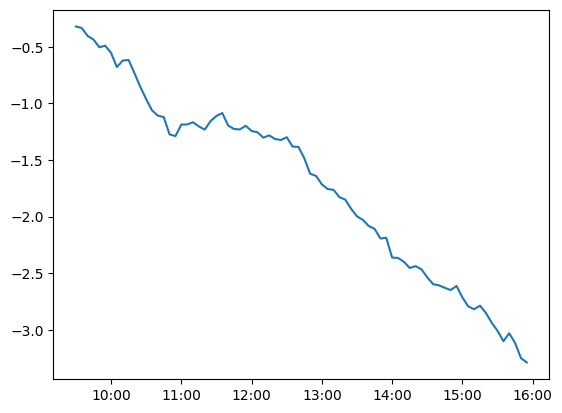

1/1 [==============================] - 0s 117ms/step
09:35:00:0


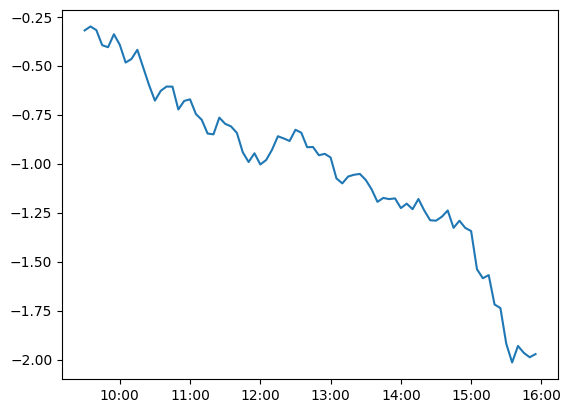

1/1 [==============================] - 0s 112ms/step
09:40:00:0


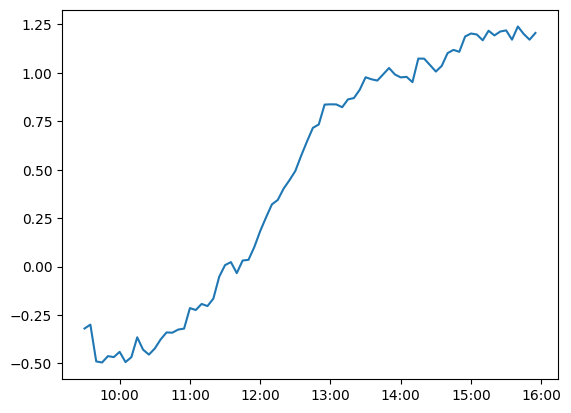

1/1 [==============================] - 0s 110ms/step
09:45:00:0


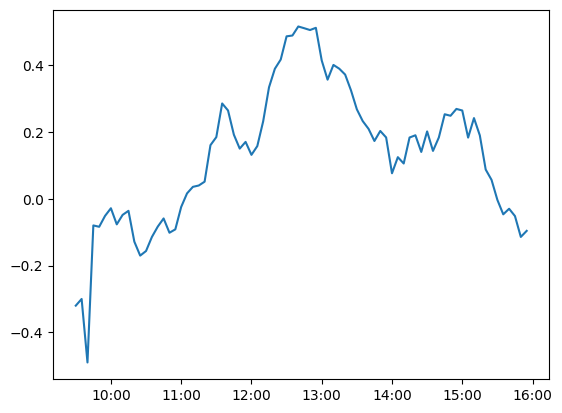

1/1 [==============================] - 0s 128ms/step
BUY
09:50:00:0.30000000000001137


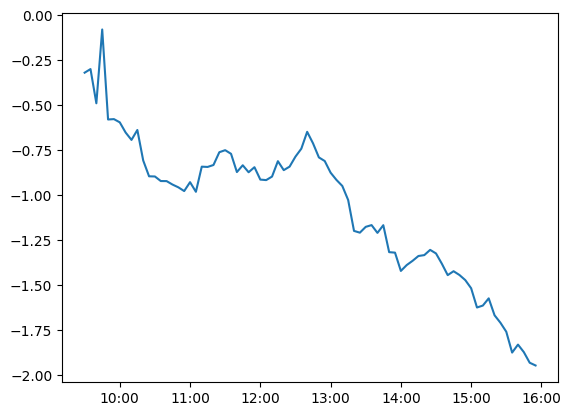

1/1 [==============================] - 0s 109ms/step
09:55:00:0.30000000000001137


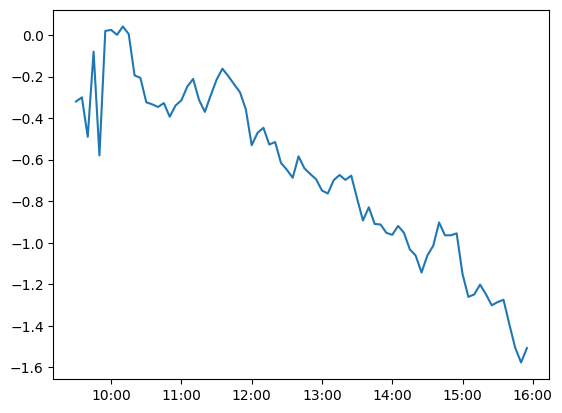

1/1 [==============================] - 0s 137ms/step
10:00:00:0.30000000000001137


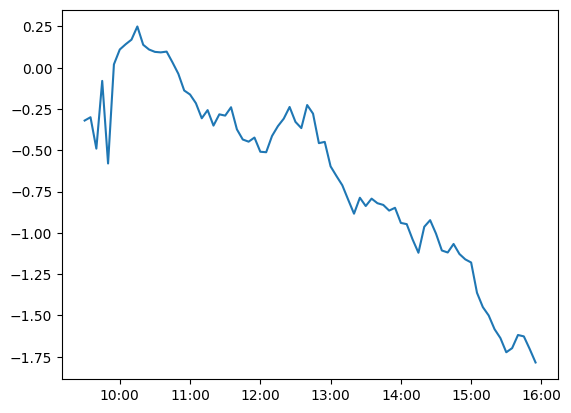

1/1 [==============================] - 0s 128ms/step
10:05:00:0.30000000000001137


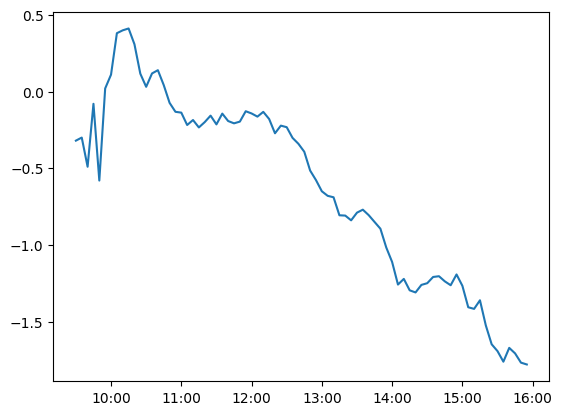

1/1 [==============================] - 0s 111ms/step
10:10:00:0.30000000000001137


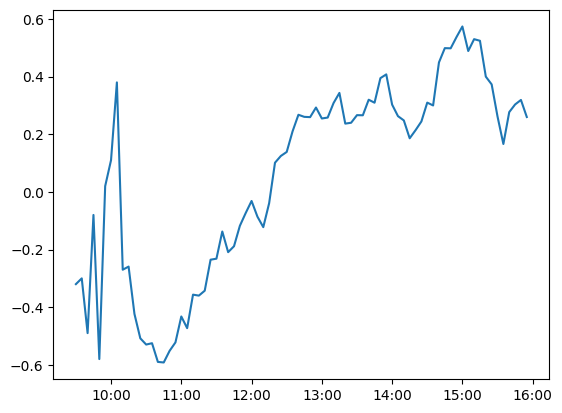

1/1 [==============================] - 0s 118ms/step
10:15:00:0.30000000000001137


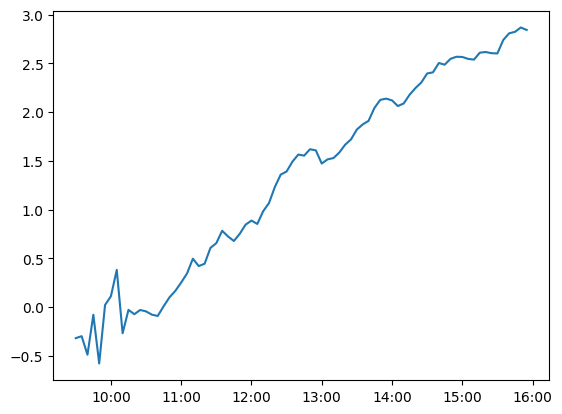

1/1 [==============================] - 0s 110ms/step
GOSHORT
10:20:00:0.30000000000001137


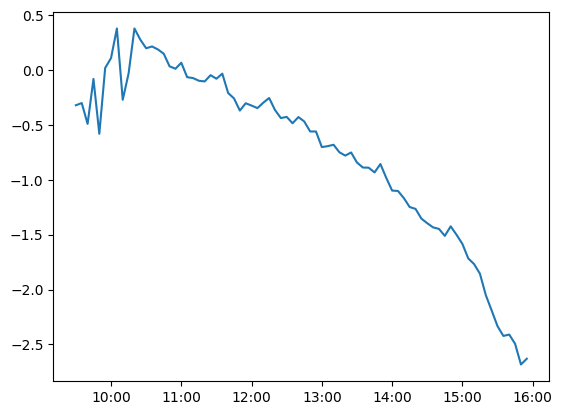

1/1 [==============================] - 0s 112ms/step
BUY
10:25:00:0.410000000000025


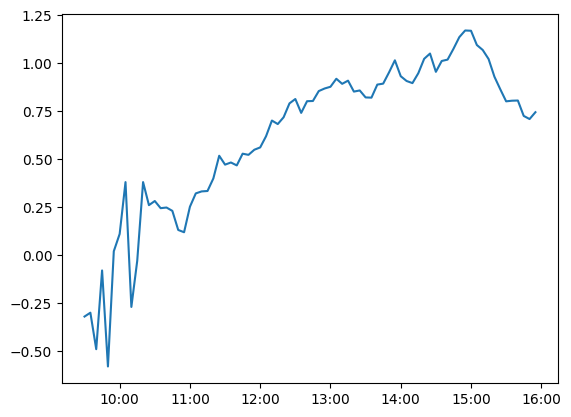

1/1 [==============================] - 0s 110ms/step
GOLONG
10:30:00:0.410000000000025


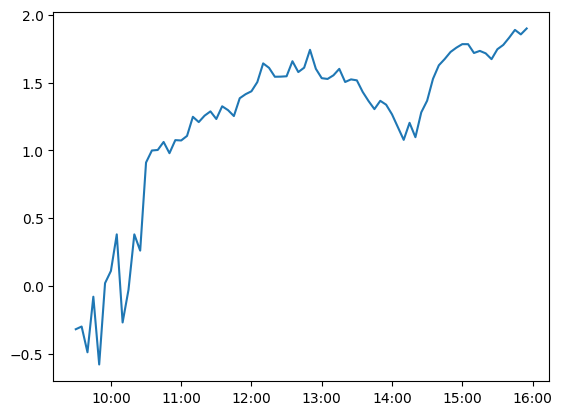

1/1 [==============================] - 0s 137ms/step
SELL
10:35:00:0.28000000000002956


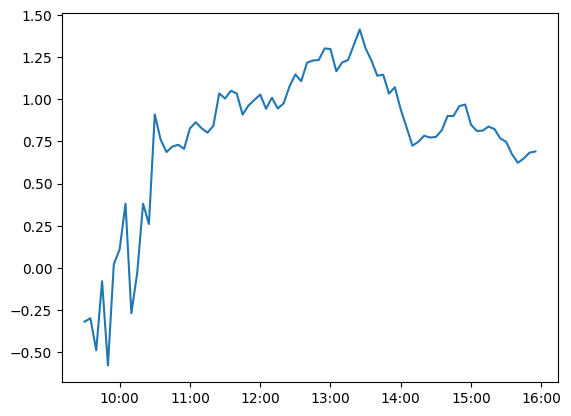

1/1 [==============================] - 0s 127ms/step
GOSHORT
10:40:00:0.28000000000002956


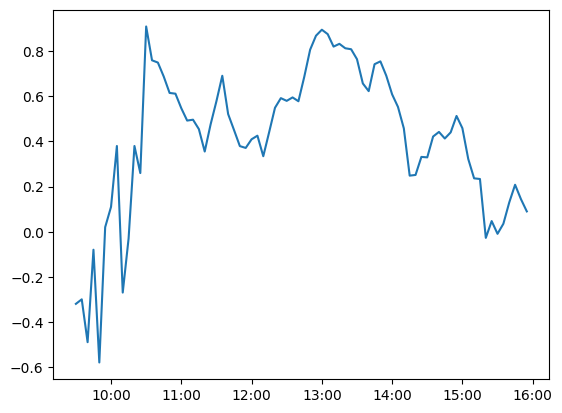

1/1 [==============================] - 0s 113ms/step
10:45:00:0.28000000000002956


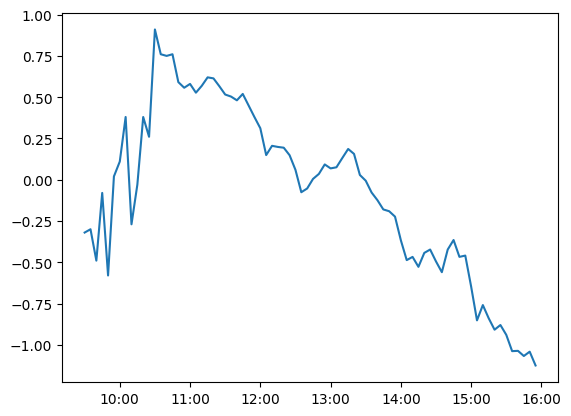

1/1 [==============================] - 0s 110ms/step
10:50:00:0.28000000000002956


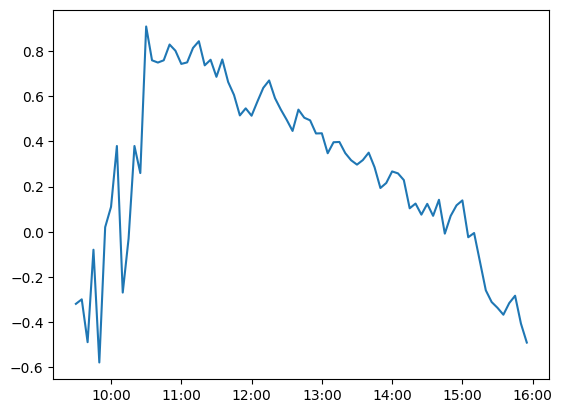

1/1 [==============================] - 0s 132ms/step
10:55:00:0.28000000000002956


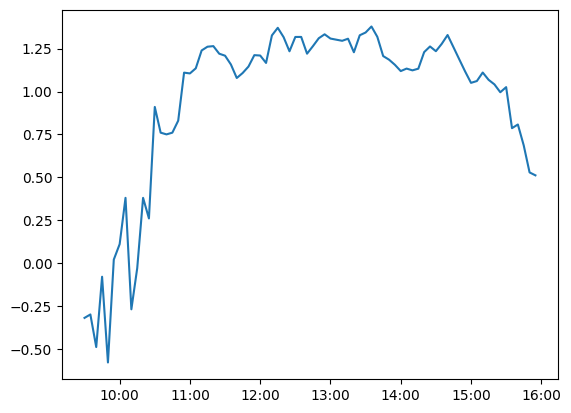

1/1 [==============================] - 0s 143ms/step
11:00:00:0.28000000000002956


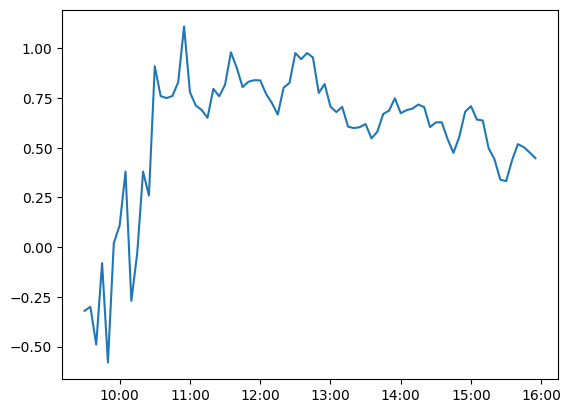

1/1 [==============================] - 0s 111ms/step
GOLONG
11:05:00:0.410000000000025


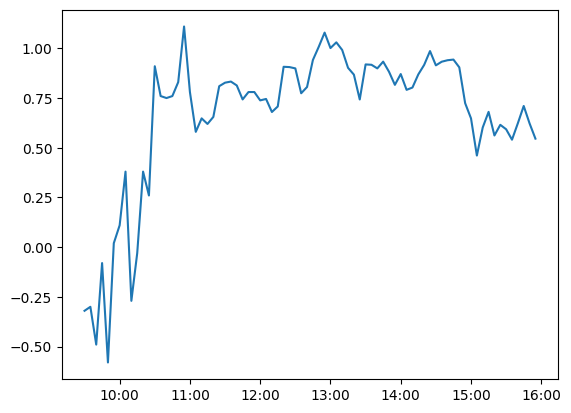

1/1 [==============================] - 0s 130ms/step
11:10:00:0.410000000000025


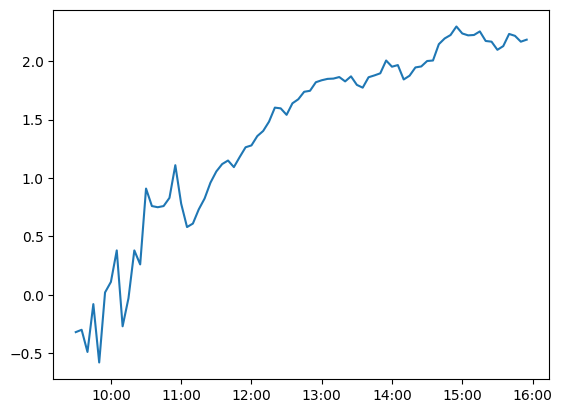

1/1 [==============================] - 0s 143ms/step
SELL
11:15:00:0.57000000000005


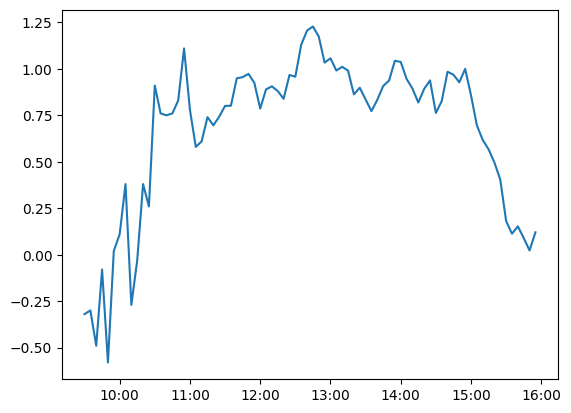

1/1 [==============================] - 0s 130ms/step
GOLONG
11:20:00:0.57000000000005


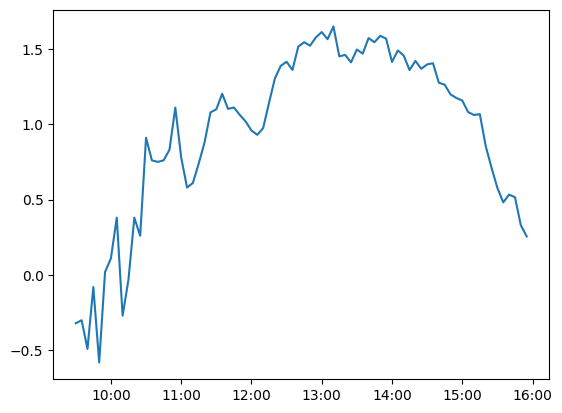

1/1 [==============================] - 0s 125ms/step
11:25:00:0.57000000000005


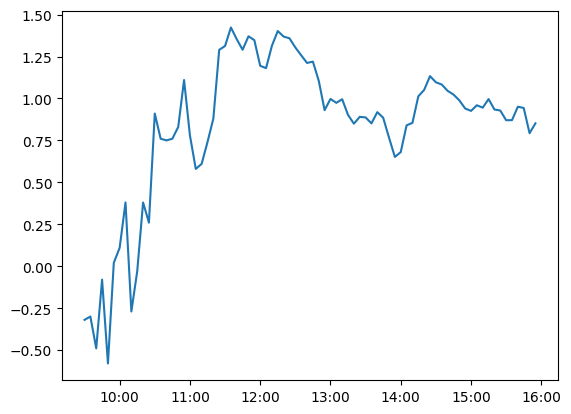

1/1 [==============================] - 0s 109ms/step
11:30:00:0.57000000000005


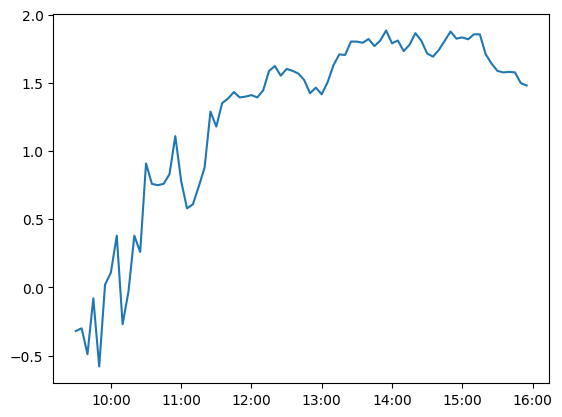

1/1 [==============================] - 0s 121ms/step
SELL
11:35:00:1.2100000000000364


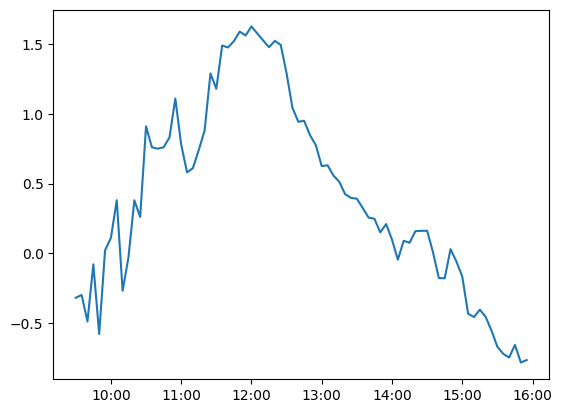

1/1 [==============================] - 0s 127ms/step
GOSHORT
11:40:00:1.2100000000000364


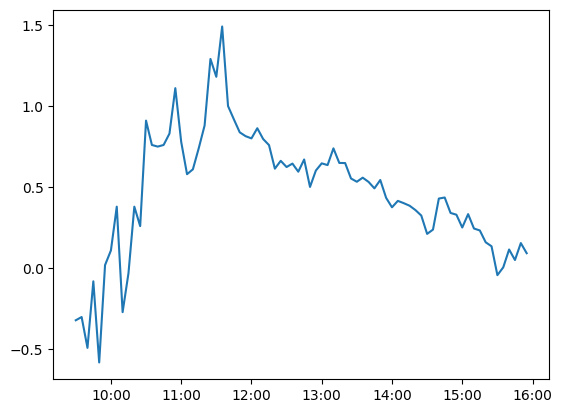

1/1 [==============================] - 0s 124ms/step
11:45:00:1.2100000000000364


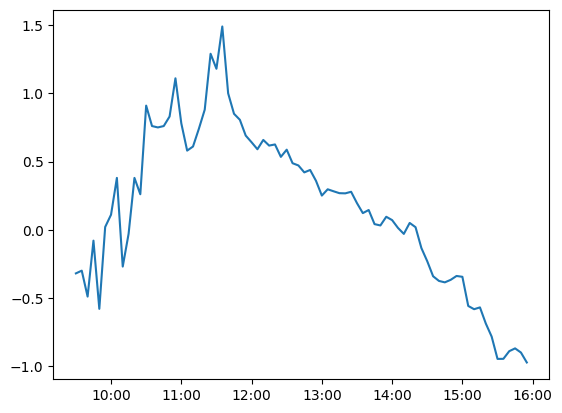

1/1 [==============================] - 0s 111ms/step
GOLONG
11:50:00:1.579999999999984


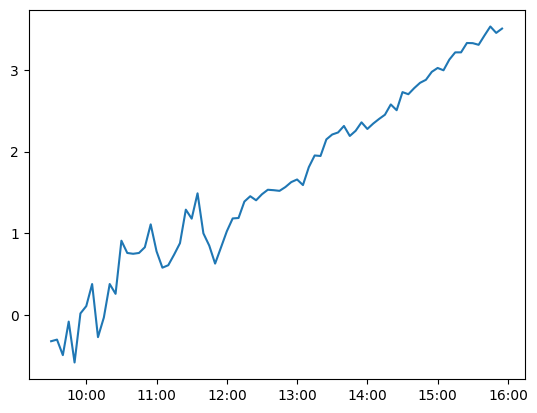

1/1 [==============================] - 0s 112ms/step
GOSHORT
11:55:00:1.2699999999999818


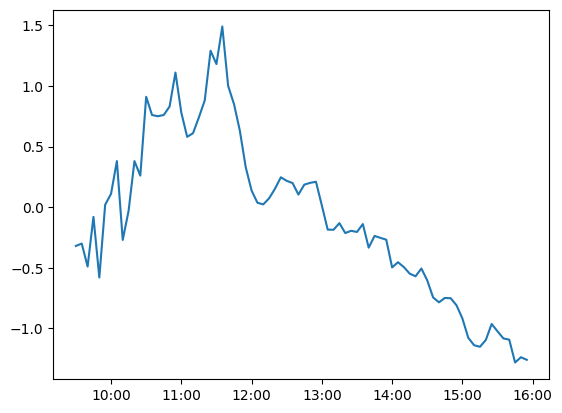

1/1 [==============================] - 0s 125ms/step
BUY
12:00:00:1.3199999999999932


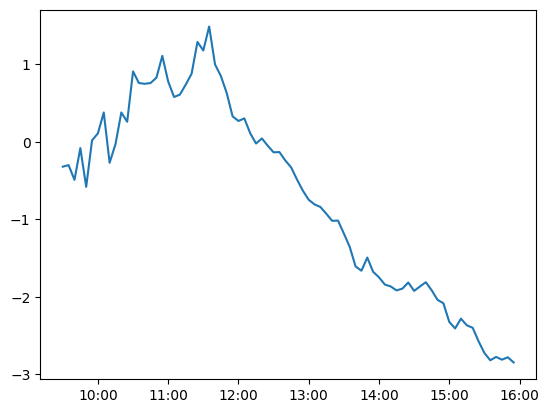

1/1 [==============================] - 0s 111ms/step
GOSHORT
12:05:00:1.3199999999999932


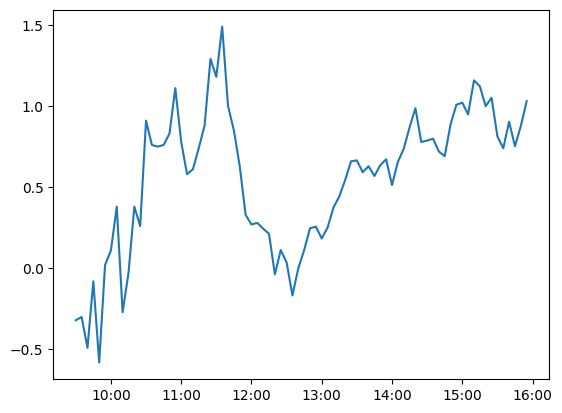

1/1 [==============================] - 0s 110ms/step
GOLONG
12:10:00:1.2199999999999704


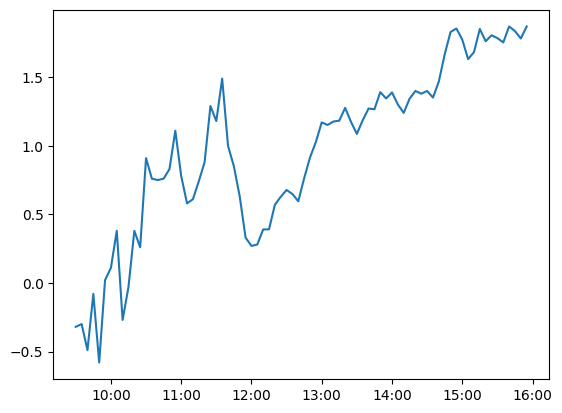

1/1 [==============================] - 0s 117ms/step
12:15:00:1.2199999999999704


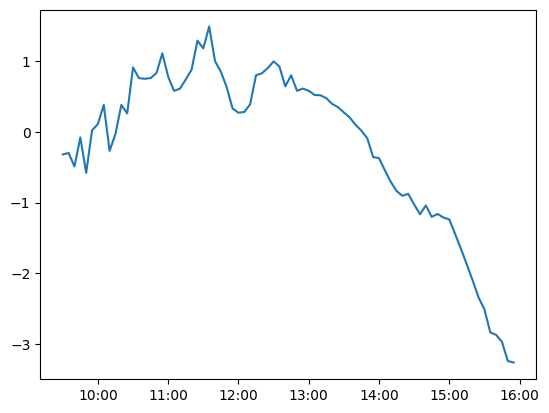

1/1 [==============================] - 0s 108ms/step
GOSHORT
12:20:00:1.6199999999999477


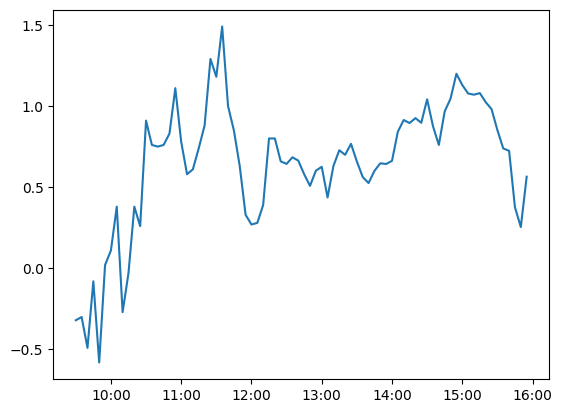

1/1 [==============================] - 0s 109ms/step
12:25:00:1.6199999999999477


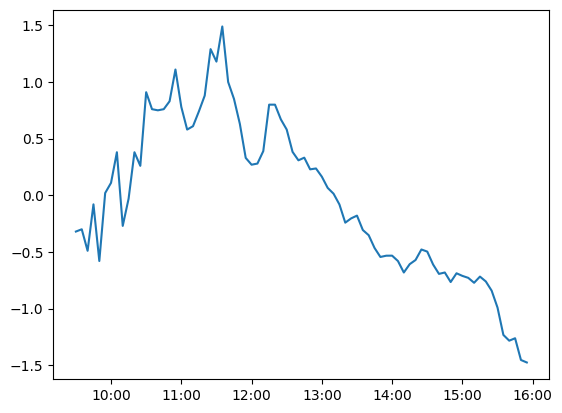

1/1 [==============================] - 0s 109ms/step
12:30:00:1.6199999999999477


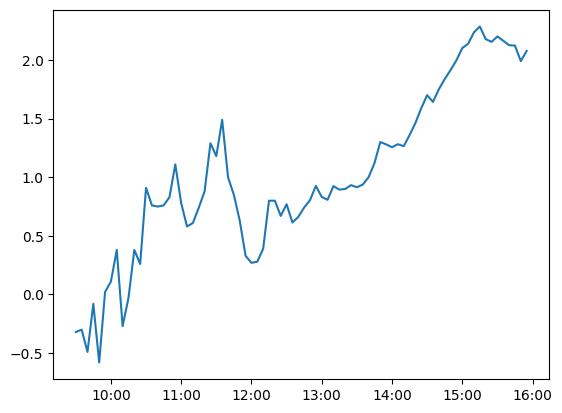

1/1 [==============================] - 0s 111ms/step
12:35:00:1.6199999999999477


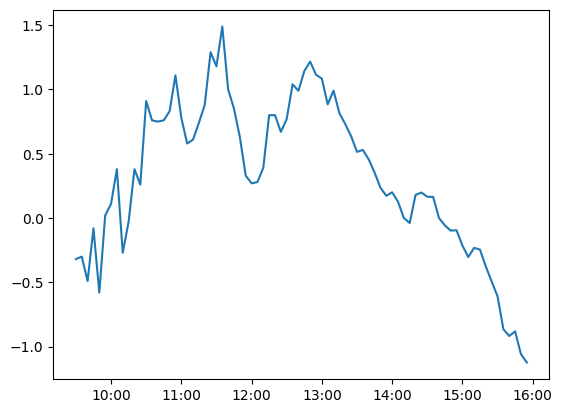

1/1 [==============================] - 0s 110ms/step
BUY
12:40:00:1.3299999999999272


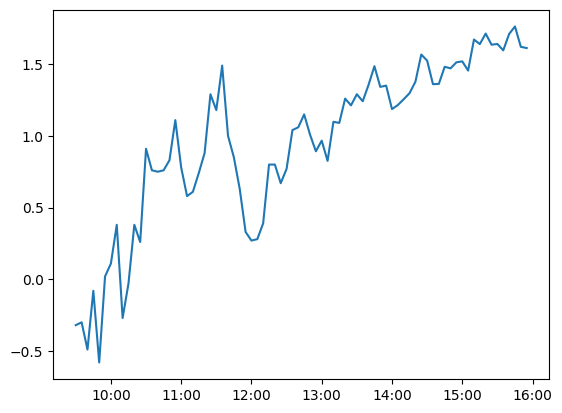

1/1 [==============================] - 0s 109ms/step
12:45:00:1.3299999999999272


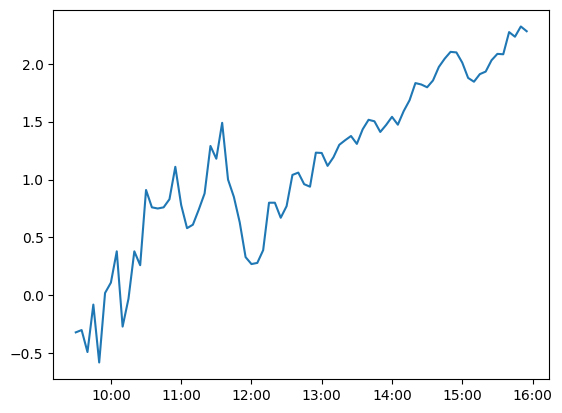

1/1 [==============================] - 0s 110ms/step
GOSHORT
12:50:00:1.3299999999999272


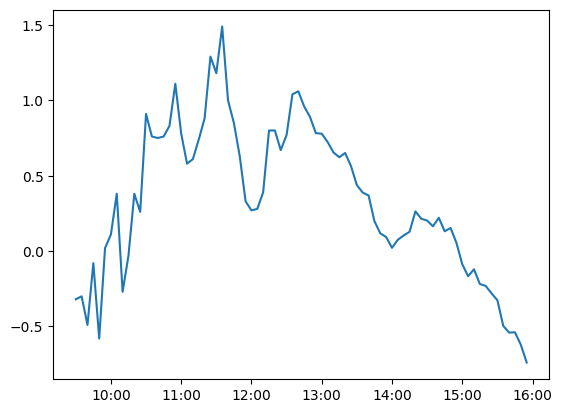

1/1 [==============================] - 0s 111ms/step
12:55:00:1.3299999999999272


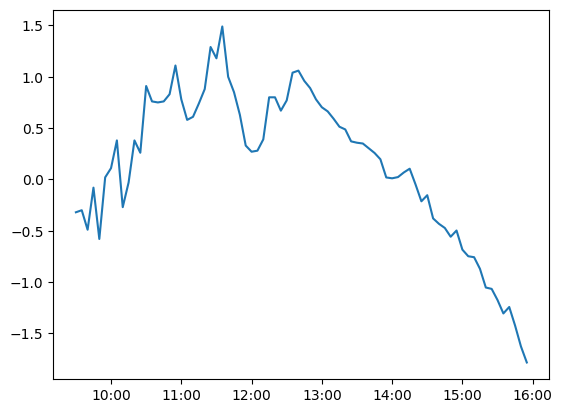

1/1 [==============================] - 0s 110ms/step
BUY
13:00:00:1.4499999999999318


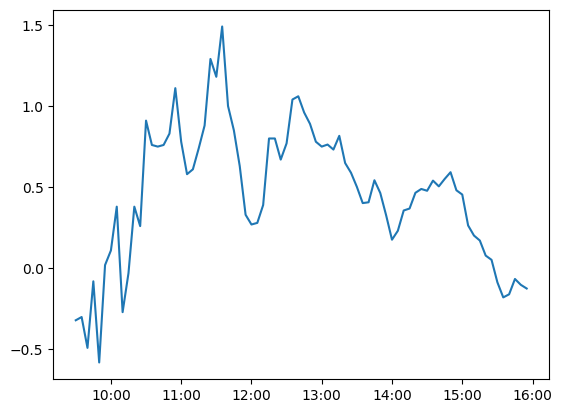

1/1 [==============================] - 0s 109ms/step
GOLONG
13:05:00:1.4499999999999318


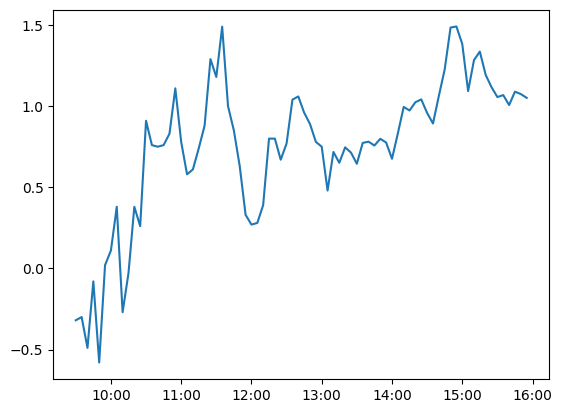

1/1 [==============================] - 0s 110ms/step
13:10:00:1.4499999999999318


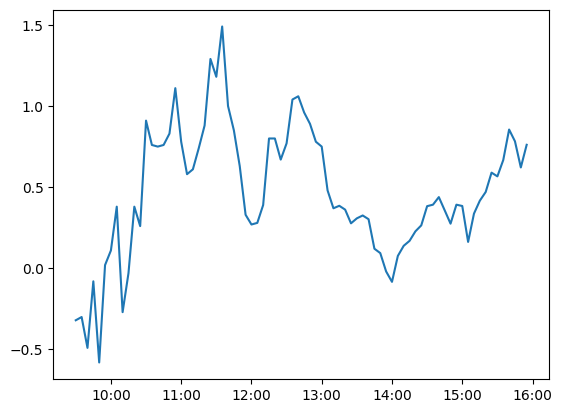

1/1 [==============================] - 0s 109ms/step
GOSHORT
13:15:00:1.0799999999999272


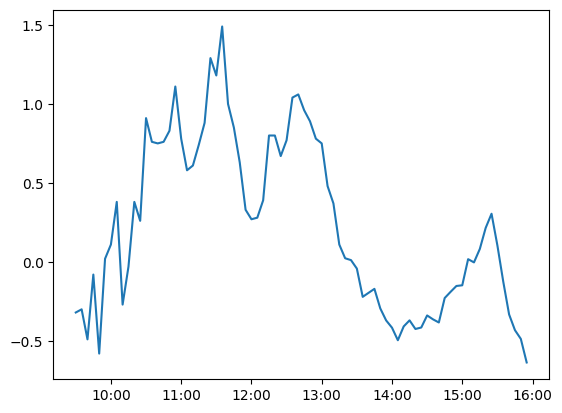

1/1 [==============================] - 0s 108ms/step
13:20:00:1.0799999999999272


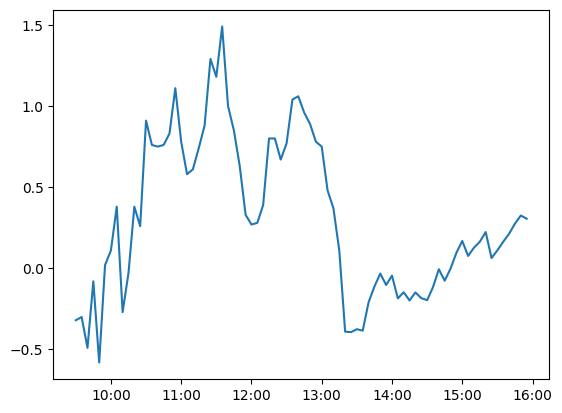

1/1 [==============================] - 0s 108ms/step
GOLONG
13:25:00:1.67999999999995


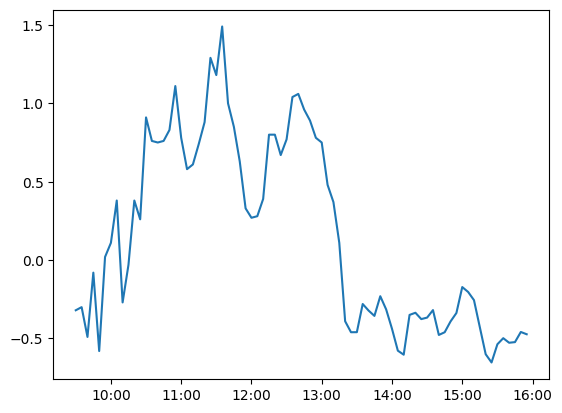

1/1 [==============================] - 0s 109ms/step
13:30:00:1.67999999999995


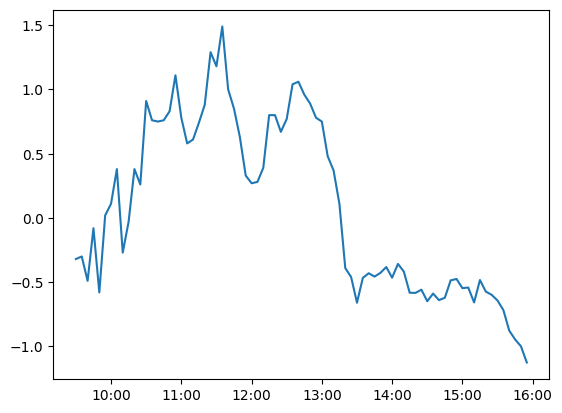

1/1 [==============================] - 0s 108ms/step
13:35:00:1.67999999999995


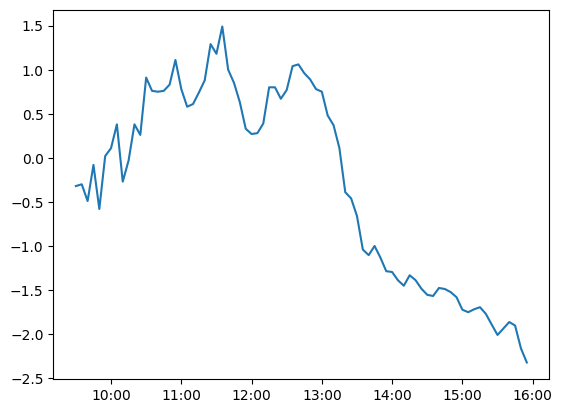

1/1 [==============================] - 0s 108ms/step
SELL
13:40:00:0.9099999999999682


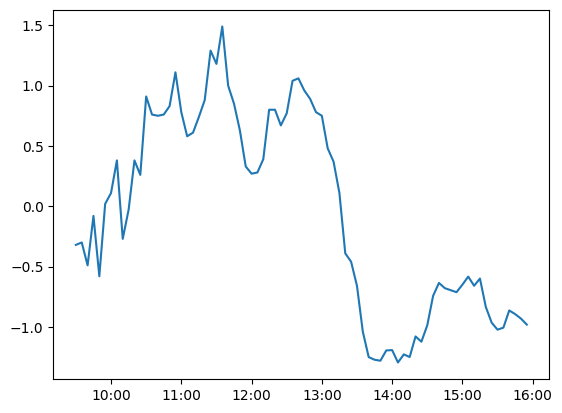

1/1 [==============================] - 0s 108ms/step
GOSHORT
13:45:00:0.9099999999999682


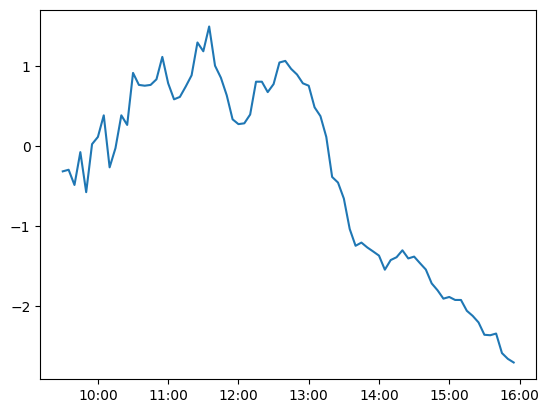

1/1 [==============================] - 0s 116ms/step
BUY
13:50:00:0.6099999999999568


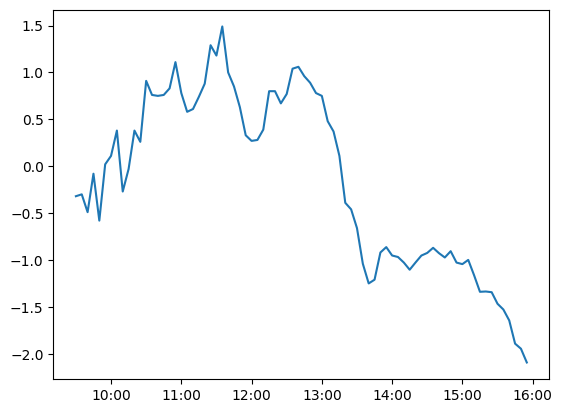

1/1 [==============================] - 0s 109ms/step
GOLONG
13:55:00:0.6099999999999568


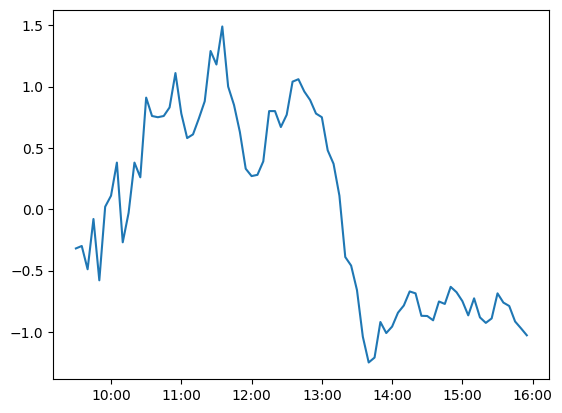

1/1 [==============================] - 0s 107ms/step
GOSHORT
14:00:00:0.5499999999999545


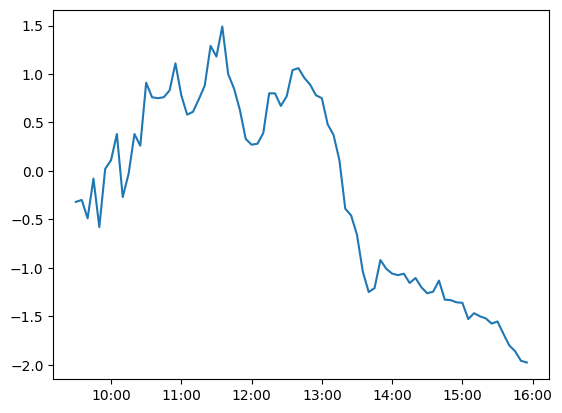

1/1 [==============================] - 0s 109ms/step
BUY
14:05:00:0.5799999999999841


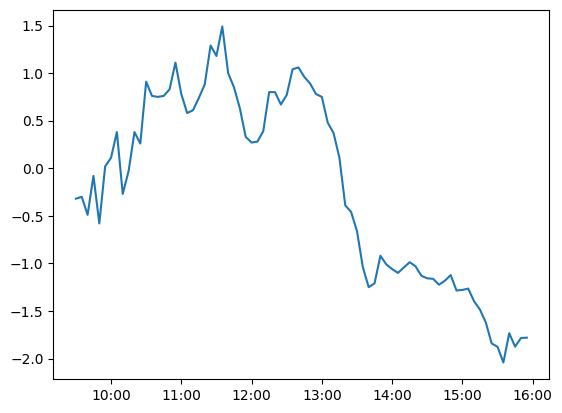

1/1 [==============================] - 0s 109ms/step
14:10:00:0.5799999999999841


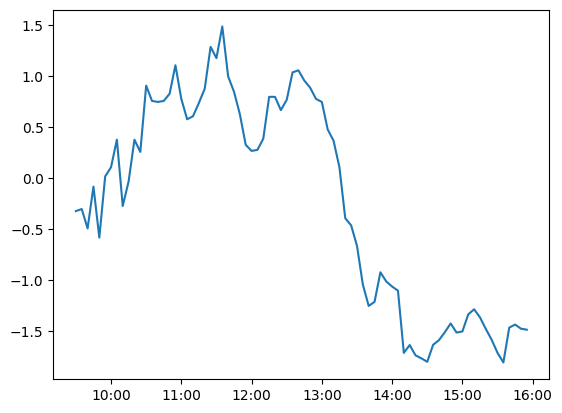

1/1 [==============================] - 0s 110ms/step
14:15:00:0.5799999999999841


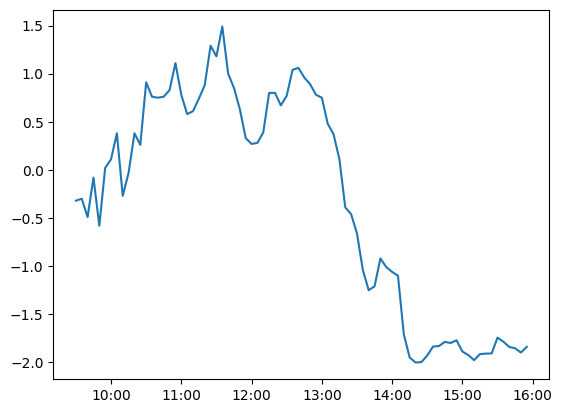

1/1 [==============================] - 0s 109ms/step
GOLONG
14:20:00:0.5799999999999841


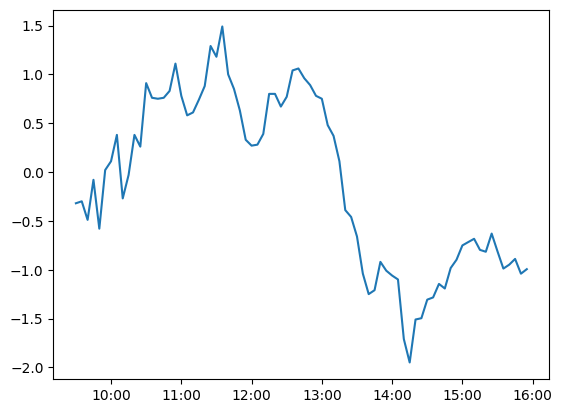

1/1 [==============================] - 0s 109ms/step
14:25:00:0.5799999999999841


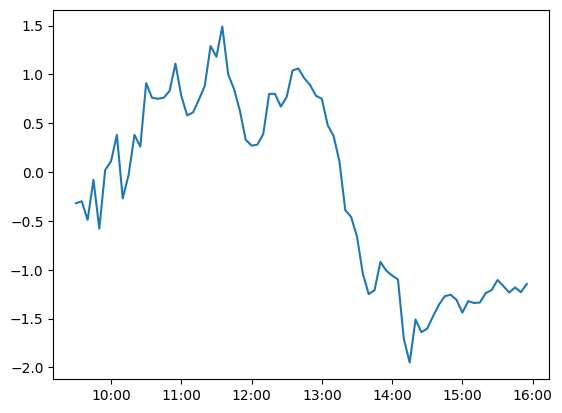

1/1 [==============================] - 0s 109ms/step
GOSHORT
14:30:00:0.5999999999999659


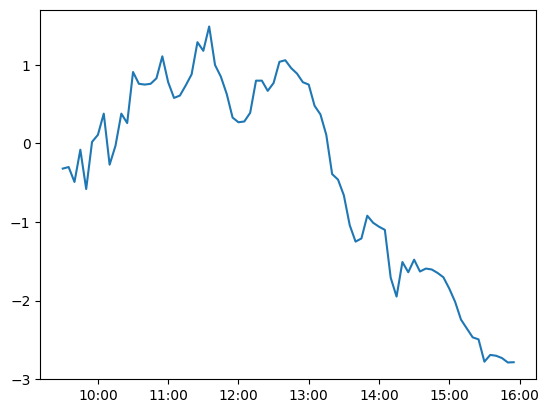

1/1 [==============================] - 0s 109ms/step
BUY
14:35:00:0.8899999999999295


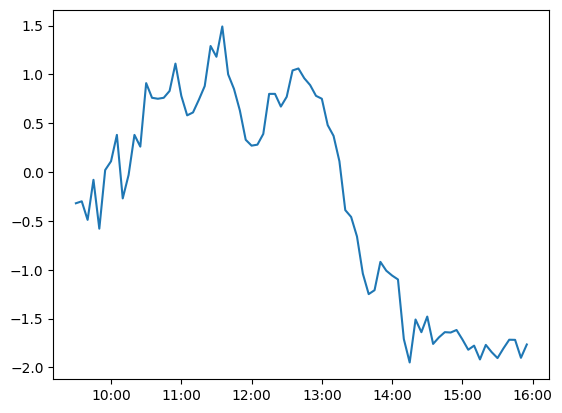

1/1 [==============================] - 0s 109ms/step
14:40:00:0.8899999999999295


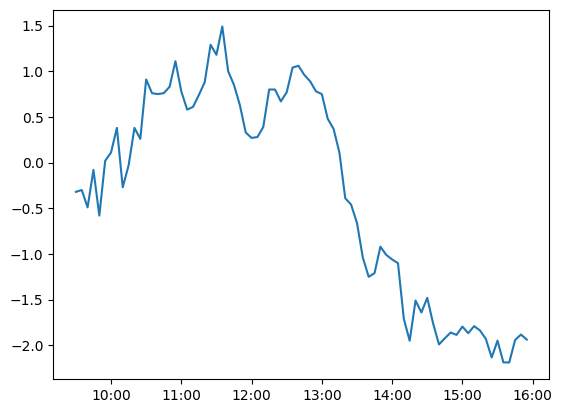

1/1 [==============================] - 0s 108ms/step
14:45:00:0.8899999999999295


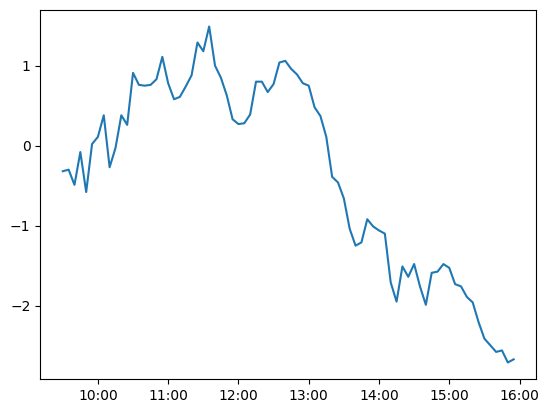

1/1 [==============================] - 0s 109ms/step
14:50:00:0.8899999999999295


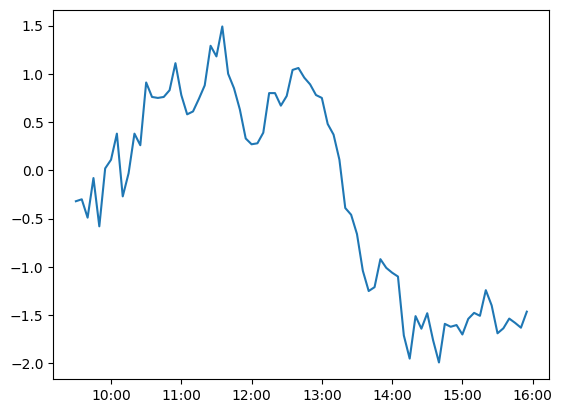

1/1 [==============================] - 0s 108ms/step
GOSHORT
14:55:00:0.8899999999999295


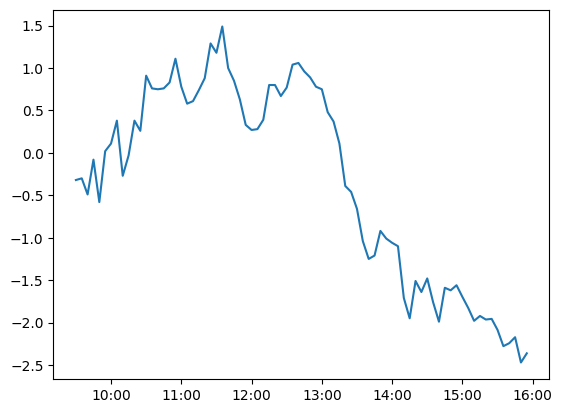

1/1 [==============================] - 0s 110ms/step
BUY
15:00:00:0.2999999999998977


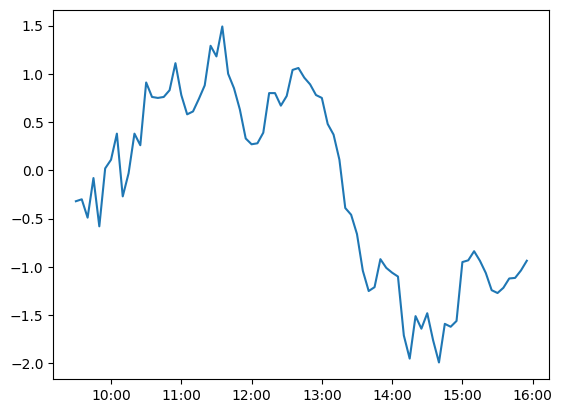

1/1 [==============================] - 0s 108ms/step
15:05:00:0.2999999999998977


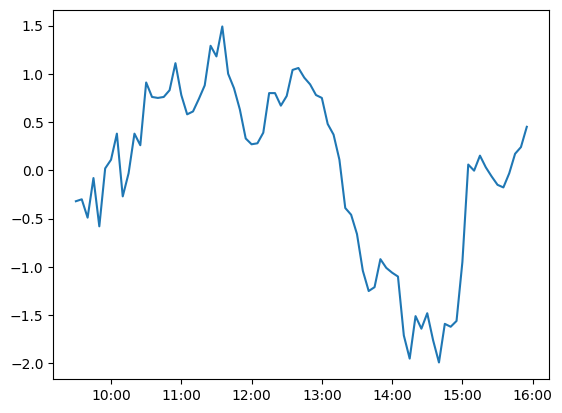

1/1 [==============================] - 0s 111ms/step
15:10:00:0.2999999999998977


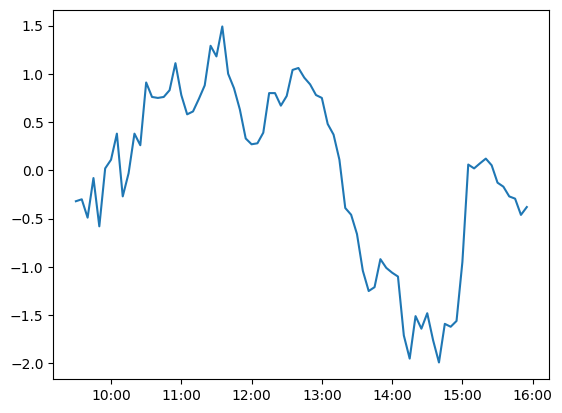

1/1 [==============================] - 0s 111ms/step
15:15:00:0.2999999999998977


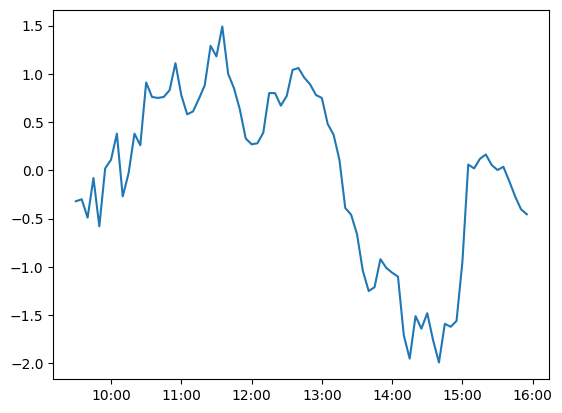

1/1 [==============================] - 0s 110ms/step
GOLONG
15:20:00:0.2999999999998977


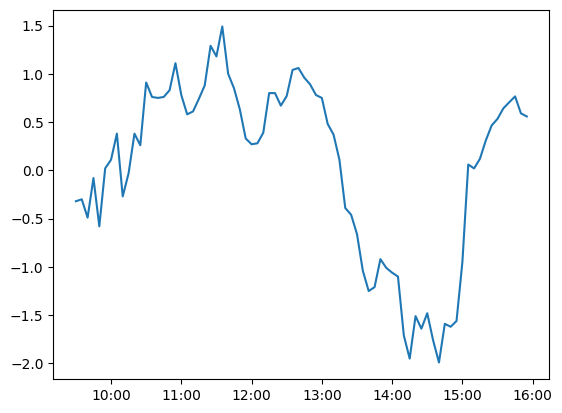

1/1 [==============================] - 0s 111ms/step
15:25:00:0.2999999999998977


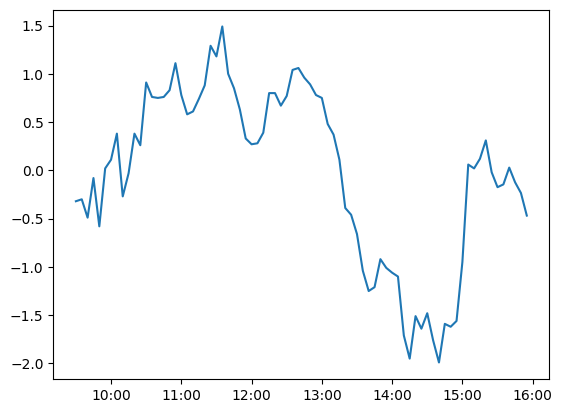

1/1 [==============================] - 0s 109ms/step
GOSHORT
15:30:00:-0.6100000000001273


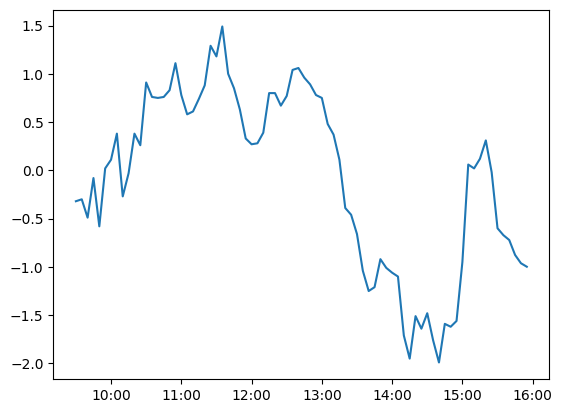

1/1 [==============================] - 0s 112ms/step
BUY
15:35:00:-0.5600000000001728


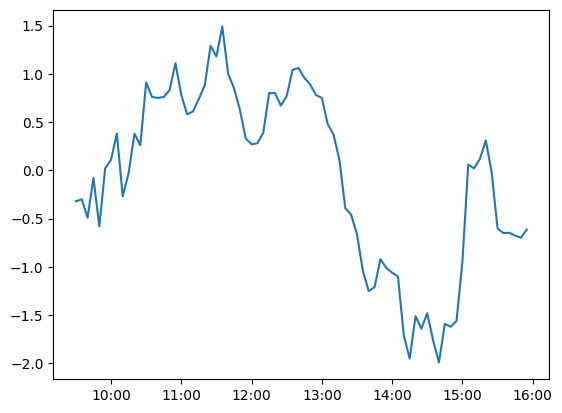

1/1 [==============================] - 0s 111ms/step
15:40:00:-0.5600000000001728


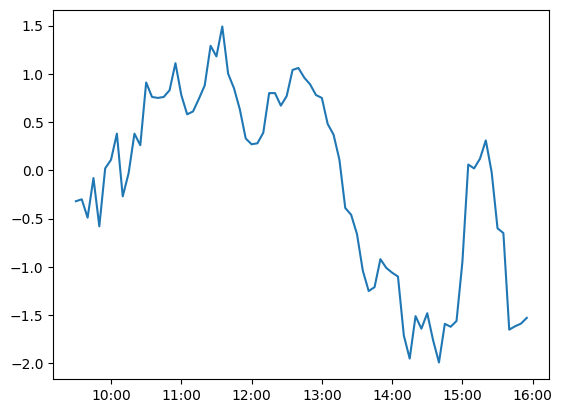

1/1 [==============================] - 0s 110ms/step
15:45:00:-0.5600000000001728


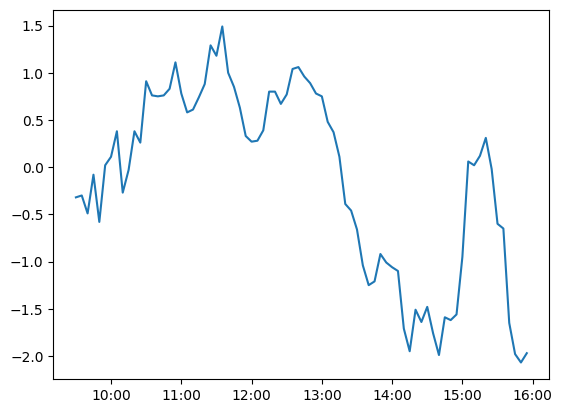

0.7599999999998772


In [ ]:
import ibapi
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract
from ibapi.order import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
import tensorflow as tf
from tensorflow import keras
from time import sleep
from datetime import datetime, date, timedelta, time
from sklearn.preprocessing import MinMaxScaler
import threading

scaler = MinMaxScaler()
df = pd.read_csv('C:\\src\\stockPredictor\\SpyHist.csv', index_col=0)

df['DateTime'] = pd.to_datetime(df['DateTime'])
df['date'] = [d.date() for d in df['DateTime']]
df['time'] = [d.time() for d in df['DateTime']]
df['Open'] = df['Open'].astype(float)
df['Close'] = df['Close'].astype(float)
df['Volume'] = df['Volume'].astype(int)
df['slowsma'] = df['Close'].rolling(21).mean()
df['fastsma'] = df['Close'].rolling(9).mean()
df['Difference'] = df['Close'] - df['Open']
df = df.dropna()

for currentDate in df.date.unique():
    if len(df.date.unique()) > len(df.loc[df['date'] == currentDate]):
        df = df.loc[df['date'] != currentDate]
        
scaler = MinMaxScaler()
scalerResult = MinMaxScaler()

df[['Volume', 'slowsma', 'fastsma']] = scaler.fit_transform(df[['Volume', 'slowsma', 'fastsma']])
df[['Difference']] = scalerResult.fit_transform(df[['Difference']])

# new_day_data = pd.read_csv('C:\\src\\stockPredictor\\dailySpy.csv', index_col=0)
# new_day_data['DateTime'] = pd.to_datetime(new_day_data['DateTime'])
# new_day_data['Difference'] = new_day_data['Difference'].astype(float)
# new_day_data['Open'] = new_day_data['Open'].astype(float)
# new_day_data['Close'] = new_day_data['Close'].astype(float)
# new_day_data['date'] = [d.date() for d in new_day_data['DateTime']]
# new_day_data['time'] = [d.time() for d in new_day_data['DateTime']]
# new_day_data[['scalars']] = scaler.transform(new_day_data[['Difference']])

new_day_data = df.loc[df['date'] == (datetime.today() - timedelta(days=1)).date()]

lastPrice = 0
totalWin = 0


long = False
short = False

# class IBapi(EWrapper, EClient):
#     def __init__(self):
#         EClient.__init__(self, self)
#         self.data = [] #Initialize variable to store candle

#     def historicalData(self, reqId, bar):
#         self.data.append([bar.date, bar.open, bar.close])
        
# def run_loop():
#     app.run()

# app = IBapi()
# app.connect('127.0.0.1', 7496, 123)

# #Start the socket in a thread
# api_thread = threading.Thread(target=run_loop, daemon=True)
# api_thread.start()

# sleep(1) #Sleep interval to allow time for connection to server

# #Create contract object
# contract = Contract()
# contract.symbol = 'SPY'
# contract.secType = 'STK'
# contract.exchange = 'SMART'
# contract.currency = 'USD'

# #Request historical candles
# app.reqHistoricalData(1, contract, '', '1 D', '5 mins', 'TRADES', 1, 2, True, [])

sleep(2) #sleep to allow enough time for data to be returned

for i in range(1,len(new_day_data)-1): 
    todaysData = pd.DataFrame(new_day_data[:i])

    currentTick = todaysData.iloc[-1]
    todaysData = todaysData.loc[todaysData['time'].isin(todaysData.time.unique())]
    model = tf.keras.models.load_model('model_'+str(todaysData.iloc[-1]['time']).replace(':','_')+'.keras')
                
    X = np.array(todaysData[['Difference', 'Volume', 'slowsma', 'fastsma']])
    input_sequence = X.reshape(1, len(todaysData), 4)
    predicted_sequence = scalerResult.inverse_transform(pd.DataFrame(model.predict(input_sequence)[0], columns=['Difference']))

    todaysData[['Difference']] = scalerResult.inverse_transform(todaysData[['Difference']])
    
    dfTotal = pd.DataFrame(columns=['Total','Time'])
    total = 0
    highest = 0
    crossoverHighest = 0
    positive = predicted_sequence[0] > 0
    
    for i in range(0,len(predicted_sequence)):
        total = total + predicted_sequence[i]
        if positive:
            if total < 0:
                crossoverHighest = total
                for j in range(i+1,len(predicted_sequence)):
                    total = total + predicted_sequence[j]
                    if total > 0:
                        break
                    if crossoverHighest > total:
                        crossoverHighest = total
                break
            if highest < total:
                highest = total
        else:
            if total > 0:
                crossoverHighest = total
                for j in range(i+1,len(predicted_sequence)):
                    total = total + predicted_sequence[j]
                    if total < 0:
                        break
                    if crossoverHighest < total:
                        crossoverHighest = total
                break
            if highest > total:
                highest = total
    
    highest = abs(highest)
    crossoverHighest = abs(crossoverHighest)
    percentChange = highest / todaysData.iloc[-1]['Close'] * 100
    crossoverPercentChange = crossoverHighest / todaysData.iloc[-1]['Close'] * 100

    if long == False and short == False:
        if positive and percentChange > 0.05:
            print('GOLONG')
            lastPrice = todaysData.iloc[-1]['Close']
            long = True
        if not positive and percentChange > 0.05:
            print('GOSHORT')
            lastPrice = todaysData.iloc[-1]['Close']
            short = True
    if long == True:
        if not positive and percentChange > 0.05:
            print('GOSHORT')
            totalWin = totalWin + todaysData.iloc[-1]['Close'] - lastPrice 
            lastPrice = todaysData.iloc[-1]['Close']
            long = False
            short = True
        elif not positive and crossoverPercentChange > percentChange:
            print('SELL')
            totalWin = totalWin + todaysData.iloc[-1]['Close'] - lastPrice 
            lastPrice = todaysData.iloc[-1]['Close']
            long = False
    if short == True:
        if positive and percentChange > 0.05:
            print('GOLONG')
            totalWin =  totalWin + lastPrice  - todaysData.iloc[-1]['Close']
            lastPrice = todaysData.iloc[-1]['Close']
            short = False
            long = True
        elif positive and crossoverPercentChange > percentChange:
            print('BUY')
            totalWin =  totalWin + lastPrice  - todaysData.iloc[-1]['Close']
            lastPrice = todaysData.iloc[-1]['Close']
            short = False

    print(str(todaysData.iloc[-1]['time']) + ':' + str(totalWin))

    dfTotal = pd.DataFrame(columns=['Total','Time'])
    Total = 0
    count = 0
    for currentTime in df.time.unique():
        if(todaysData.loc[todaysData['time']==currentTime].empty is False):
            Total = Total + todaysData.loc[todaysData['time']==currentTime]['Difference'].values[0]
        else:
            Total = Total + predicted_sequence[count]
            count = count + 1
        dfTotal.loc[len(dfTotal.index)] = [Total,currentTime] 
    datetimes = [datetime.combine(date.today(), t) for t in dfTotal["Time"]]
    xformatter = mdates.DateFormatter('%H:%M')
    plt.plot(datetimes, dfTotal["Total"], label = "curve 1")
    plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
    plt.show()

    timeToWait = 3
    if timeToWait > 0:
        sleep(timeToWait)

totalWin =  totalWin + abs(lastPrice  - todaysData.iloc[-1]['Close'])
print(totalWin)

In [ ]:
df.dropna()

,DateTime,Open,Close,Volume,date,time,slowsma,fastsma,Difference
20,2023-03-27 11:10:00-04:00,396.10,396.45,473077,2023-03-27,11:10:00,397.345238,396.572222,0.35
21,2023-03-27 11:15:00-04:00,396.42,395.96,530138,2023-03-27,11:15:00,397.226190,396.487778,-0.46
22,2023-03-27 11:20:00-04:00,395.96,396.27,399588,2023-03-27,11:20:00,397.167619,396.428889,0.31
23,2023-03-27 11:25:00-04:00,396.27,396.61,537667,2023-03-27,11:25:00,397.080000,396.442222,0.34
24,2023-03-27 11:30:00-04:00,396.63,396.72,442307,2023-03-27,11:30:00,396.989524,396.437778,0.09
...,...,...,...,...,...,...,...,...,...
9709,2023-09-22 15:35:00-04:00,432.02,431.97,838136,2023-09-22,15:35:00,431.591905,432.254444,-0.05
9710,2023-09-22 15:40:00-04:00,431.98,430.98,1722700,2023-09-22,15:40:00,431.561429,432.244444,-1.00
9711,2023-09-22 15:45:00-04:00,430.98,430.65,3680855,2023-09-22,15:45:00,431.518095,432.132222,-0.33
9712,2023-09-22 15:50:00-04:00,430.64,430.24,4106375,2023-09-22,15:50:00,431.456667,431.862222,-0.40


In [ ]:
app.disconnect()

In [ ]:
df

,DateTime,Open,Close,Volume,date,time,slowsma,fastsma,Difference
3588,2023-06-01 09:30:00-04:00,418.09,417.22,0.176255,2023-06-01,09:30:00,0.007327,0.017583,0.264305
3589,2023-06-01 09:35:00-04:00,417.22,417.66,0.154571,2023-06-01,09:35:00,0.006432,0.016297,0.621253
3590,2023-06-01 09:40:00-04:00,417.66,417.32,0.089774,2023-06-01,09:40:00,0.004960,0.013911,0.408719
3591,2023-06-01 09:45:00-04:00,417.32,417.18,0.095274,2023-06-01,09:45:00,0.003699,0.010802,0.463215
3592,2023-06-01 09:50:00-04:00,417.18,417.08,0.111295,2023-06-01,09:50:00,0.002003,0.007237,0.474114
...,...,...,...,...,...,...,...,...,...
9631,2023-09-21 15:35:00-04:00,431.96,432.16,0.182558,2023-09-21,15:35:00,0.379073,0.364640,0.555858
9632,2023-09-21 15:40:00-04:00,432.15,432.22,0.225323,2023-09-21,15:40:00,0.376481,0.362335,0.520436
9633,2023-09-21 15:45:00-04:00,432.21,432.10,0.224512,2023-09-21,15:45:00,0.374137,0.359306,0.471390
9634,2023-09-21 15:50:00-04:00,432.10,431.90,0.436675,2023-09-21,15:50:00,0.371616,0.356331,0.446866
